# Fake news detection using ML 


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import f_regression, mutual_info_regression

## import datasets

In [2]:
fake = pd.read_csv("dataset/Fake.csv")
true = pd.read_csv("dataset/True.csv")

In [3]:
fake.shape

(11996, 4)

In [4]:
true.shape

(10998, 4)

## Data cleaning and preparation

In [5]:
# Add target label fake and real
fake['target'] = 0
true['target'] = 1

0-fake
1-true


In [6]:
# Concatenate data
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(22994, 5)

In [7]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
data.head()

,title,text,subject,date,target
0,Trump says he has not obstructed FBI's probe R...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"June 23, 2017",1
1,Attorney General Sessions to talk publicly to ...,WASHINGTON (Reuters) - U.S. Attorney General J...,politicsNews,"June 11, 2017",1
2,Trump to meet Canada's PM amid tensions over t...,OTTAWA (Reuters) - Canadian Prime Minister Jus...,politicsNews,"February 9, 2017",1
3,Turkey summons U.S. consulate worker for quest...,ANKARA (Reuters) - Turkish authorities summone...,politicsNews,"October 9, 2017",1
4,NAACP PRESIDENT Shocks Locals with Stance on C...,I think it s all senseless. All senseless. ...,politics,"Aug 20, 2017",0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22994 entries, 0 to 22993
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    22994 non-null  object
 1   text     22994 non-null  object
 2   subject  22993 non-null  object
 3   date     22993 non-null  object
 4   target   22994 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 898.3+ KB


In [10]:
data.isnull().sum()

title      0
text       0
subject    1
date       1
target     0
dtype: int64

In [11]:
data = data.dropna()

In [12]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [13]:
data.shape

(22993, 5)

In [14]:
# Removing the date
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Trump says he has not obstructed FBI's probe R...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,1
1,Attorney General Sessions to talk publicly to ...,WASHINGTON (Reuters) - U.S. Attorney General J...,politicsNews,1
2,Trump to meet Canada's PM amid tensions over t...,OTTAWA (Reuters) - Canadian Prime Minister Jus...,politicsNews,1
3,Turkey summons U.S. consulate worker for quest...,ANKARA (Reuters) - Turkish authorities summone...,politicsNews,1
4,NAACP PRESIDENT Shocks Locals with Stance on C...,I think it s all senseless. All senseless. ...,politics,0


In [15]:
# Removing the title
data["text"] = data["title"]+data["text"]
data.head()

,title,text,subject,target
0,Trump says he has not obstructed FBI's probe R...,Trump says he has not obstructed FBI's probe R...,politicsNews,1
1,Attorney General Sessions to talk publicly to ...,Attorney General Sessions to talk publicly to ...,politicsNews,1
2,Trump to meet Canada's PM amid tensions over t...,Trump to meet Canada's PM amid tensions over t...,politicsNews,1
3,Turkey summons U.S. consulate worker for quest...,Turkey summons U.S. consulate worker for quest...,politicsNews,1
4,NAACP PRESIDENT Shocks Locals with Stance on C...,NAACP PRESIDENT Shocks Locals with Stance on C...,politics,0


In [16]:
# Check
data.head()

,title,text,subject,target
0,Trump says he has not obstructed FBI's probe R...,Trump says he has not obstructed FBI's probe R...,politicsNews,1
1,Attorney General Sessions to talk publicly to ...,Attorney General Sessions to talk publicly to ...,politicsNews,1
2,Trump to meet Canada's PM amid tensions over t...,Trump to meet Canada's PM amid tensions over t...,politicsNews,1
3,Turkey summons U.S. consulate worker for quest...,Turkey summons U.S. consulate worker for quest...,politicsNews,1
4,NAACP PRESIDENT Shocks Locals with Stance on C...,NAACP PRESIDENT Shocks Locals with Stance on C...,politics,0


In [17]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str


In [18]:
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
port_stem = PorterStemmer()

In [19]:
port_stem=PorterStemmer()

def stemming(subhead):
    ssb = re.sub('[^a-zA-Z]',' ',subhead)
    ssb = subhead.lower()
    ssb = ssb.split()
    ssb = [port_stem.stem(word) for word in ssb if not word in stopwords.words('english')]
    ssb = ' '.join(ssb)
    return ssb

In [20]:
def stemming(text):
    stemmed_content = re.sub('[^a-zA-Z]',' ',text)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [21]:
# Removing stopwords
import nltk
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [22]:
data.head()

,title,text,subject,target
0,Trump says he has not obstructed FBI's probe R...,Trump says obstructed FBI's probe Russia probe...,politicsNews,1
1,Attorney General Sessions to talk publicly to ...,Attorney General Sessions talk publicly U.S. S...,politicsNews,1
2,Trump to meet Canada's PM amid tensions over t...,"Trump meet Canada's PM amid tensions trade, im...",politicsNews,1
3,Turkey summons U.S. consulate worker for quest...,Turkey summons U.S. consulate worker questioni...,politicsNews,1
4,NAACP PRESIDENT Shocks Locals with Stance on C...,NAACP PRESIDENT Shocks Locals Stance Confedera...,politics,0


## Basic data exploration

subject
News             9050
politics         2945
politicsNews    10998
Name: text, dtype: int64


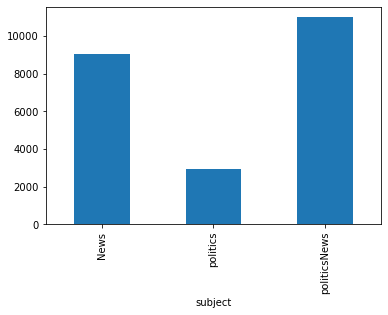

In [23]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
0    11995
1    10998
Name: text, dtype: int64


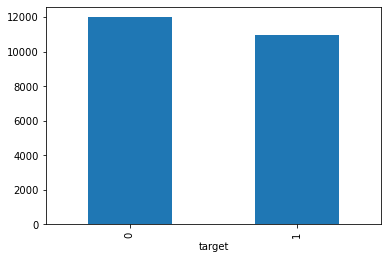

In [24]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [25]:
pip install WordCloud


Note: you may need to restart the kernel to use updated packages.


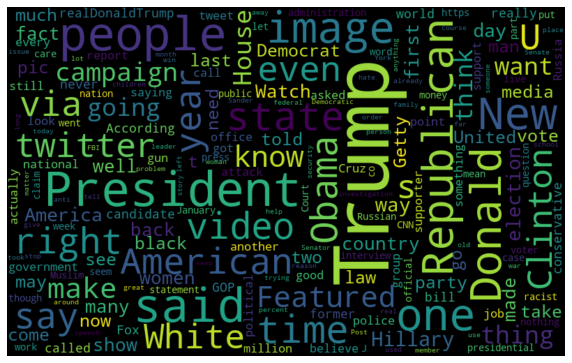

In [26]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == 0]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

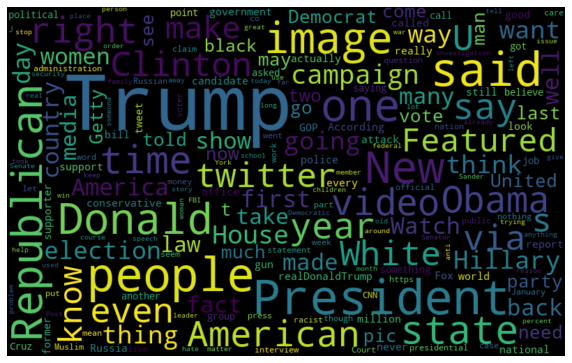

In [27]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == 1]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

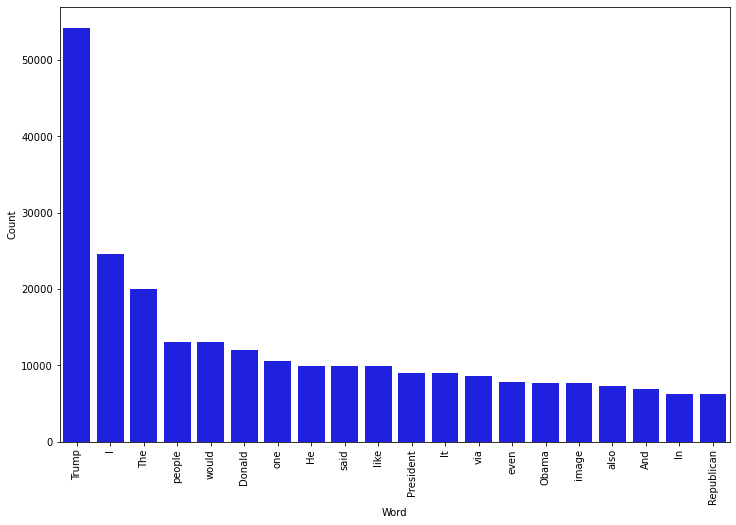

In [29]:
# Most frequent words in fake news
counter(data[data["target"] == 0], "text", 20)

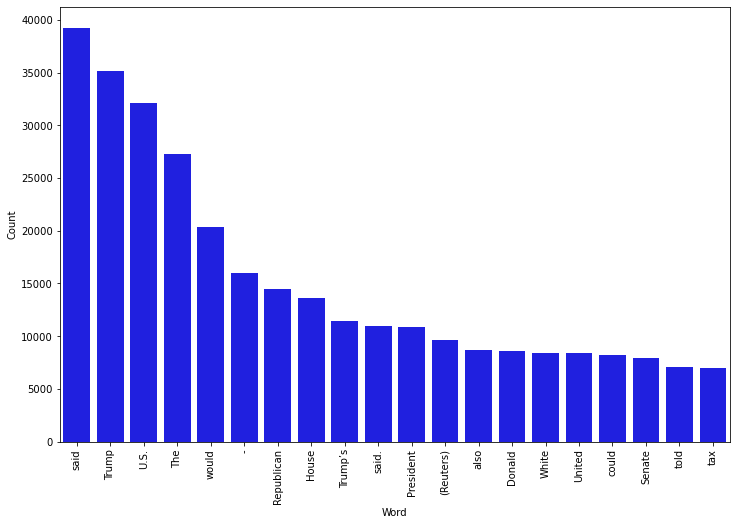

In [30]:
# Most frequent words in real news
counter(data[data["target"] == 1], "text", 20)

## Modeling

In [31]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [32]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [33]:
X_train.head()

7871     Hillary’s New 404 Page On Her Website Is Actua...
2578     ‘I’m Not A Racist’: Trump Campaign Official Bl...
14206    JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...
19793    Trump concludes Fed chair interviews, could de...
3474     NYC mayor warns Trump: 'stop frisk' make thing...
Name: text, dtype: object

# **Naive Bayes**




In [34]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 94.67%


In [35]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2415
           1       0.94      0.94      0.94      2184

    accuracy                           0.95      4599
   macro avg       0.95      0.95      0.95      4599
weighted avg       0.95      0.95      0.95      4599



Confusion matrix, without normalization


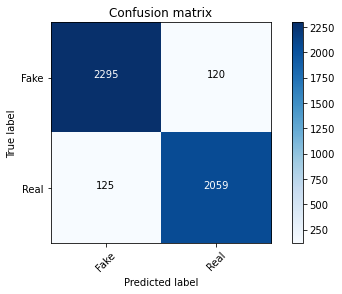

In [36]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [37]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.02%


In [38]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2415
           1       0.99      0.99      0.99      2184

    accuracy                           0.99      4599
   macro avg       0.99      0.99      0.99      4599
weighted avg       0.99      0.99      0.99      4599



Confusion matrix, without normalization


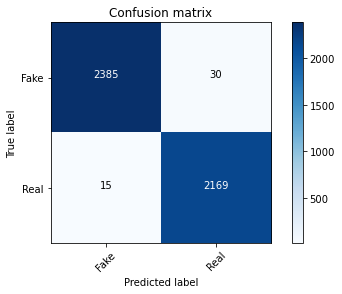

In [39]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [40]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.52%


In [41]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2415
           1       1.00      0.99      0.99      2184

    accuracy                           1.00      4599
   macro avg       1.00      1.00      1.00      4599
weighted avg       1.00      1.00      1.00      4599



Confusion matrix, without normalization


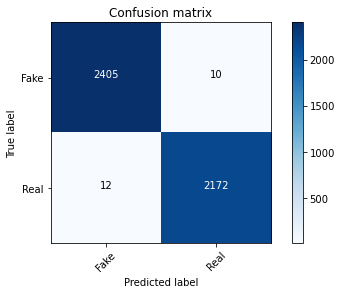

In [42]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [43]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.74%


In [44]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2415
           1       0.99      0.98      0.99      2184

    accuracy                           0.99      4599
   macro avg       0.99      0.99      0.99      4599
weighted avg       0.99      0.99      0.99      4599



Confusion matrix, without normalization


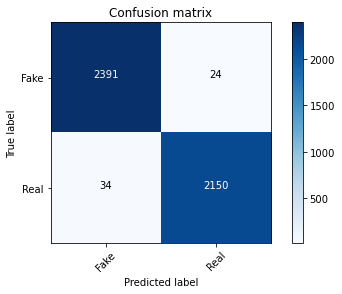

In [45]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [46]:
from sklearn import svm

clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 99.59%


In [50]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2415
           1       0.99      1.00      1.00      2184

    accuracy                           1.00      4599
   macro avg       1.00      1.00      1.00      4599
weighted avg       1.00      1.00      1.00      4599



Confusion matrix, without normalization


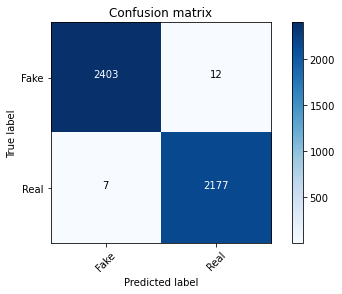

In [47]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# GradientBoostingClassifier


In [54]:

clf = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model',GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=1.0,
    max_depth=1, 
    random_state=0))])

 
# Train model
predgbc = clf.fit(X_train, y_train)
predgbc = predgbc.predict(X_test)
# Evaluate
clf.score(X_test, y_test)
dct['GradientBoosting'] = round(accuracy_score(y_test, predgbc)*100,2)

In [55]:
print(classification_report(y_test, predgbc))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2415
           1       0.99      1.00      0.99      2184

    accuracy                           0.99      4599
   macro avg       0.99      0.99      0.99      4599
weighted avg       0.99      0.99      0.99      4599



In [57]:
clf.score(X_test, y_test)

0.9926070884974995

In [59]:
from sklearn.metrics import confusion_matrix, f1_score

In [61]:
f1_score(y_test, predgbc)

0.9922515952597994

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x1ae0a6c79a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

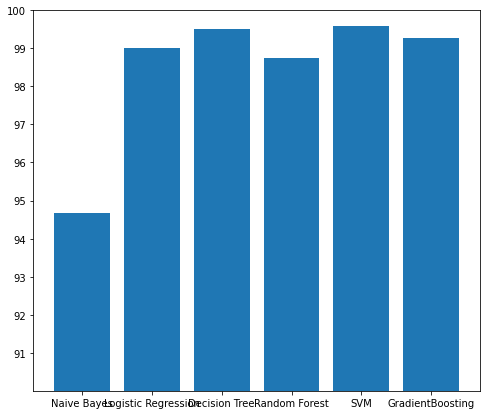

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [43]:
models = [('lr',LogisticRegression()),('svm',SVC())]
stacking = StackingClassifier(estimators=models)

In [44]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models

In [45]:
def evaluate_model(model, x, y):
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1))])
    scores = cross_val_score(model,x , y, scoring='accuracy', cv=pipe, n_jobs=-1, error_score='raise')
    
    return scores

In [67]:
clf = svm.SVC(kernel='rbf', C=1e9, gamma=1e-07, probability=True) # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

# Creating a StratifiedKFold object with 5 splits
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

scores = cross_validate(pipe, X_train, y_train,
                        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                        cv=5,
                        n_jobs=-1,
                        return_train_score=False)

print('Cross validation scores', scores)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)


Cross validation scores {'fit_time': array([2013.71125984, 1116.13448954, 1143.11432219, 1128.59001684,
       1196.9588685 ]), 'score_time': array([30.03881812, 35.65653777, 34.18616629, 35.23921704, 34.7611618 ]), 'test_accuracy': array([0.96085893, 0.95705355, 0.96140256, 0.96493612, 0.96247961]), 'test_precision_macro': array([0.96065498, 0.95682081, 0.96133484, 0.96470791, 0.96233961]), 'test_recall_macro': array([0.9613573 , 0.95743209, 0.96212834, 0.96533964, 0.96312077]), 'test_f1_macro': array([0.96082823, 0.95701299, 0.9613829 , 0.9649036 , 0.96245612])}
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2415
           1       0.95      0.97      0.96      2184

    accuracy                           0.96      4599
   macro avg       0.96      0.96      0.96      4599
weighted avg       0.96      0.96      0.96      4599

Accuracy: 0.9630354424874973


In [68]:
model_file = 'final_model.sav'
pickle.dump(pipe,open(model_file,'wb'))

In [69]:
#Plotting learing curve
def plot_learing_curve(pipeline,title):
    size = 10000
    cv = KFold(size, shuffle=True)
    
    X = DataPrep.train_news["Statement"]
    y = DataPrep.train_news["Label"]
    
    pl = pipeline
    pl.fit(X,y)
    
    train_sizes, train_scores, test_scores = learning_curve(pl, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
       
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
     
    plt.figure()
    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

In [70]:

import pickle

#doc_new = ['obama is running for president in 2016']

var = input("Please enter the news text you want to verify: ")
print("You entered: " + str(var))


#function to run for prediction
def detecting_fake_news(var):    
#retrieving the best model for prediction call
    load_model = pickle.load(open('final_model.sav', 'rb'))
    prediction = load_model.predict([var])
    prob = load_model.predict_proba([var])

    return (print("The given statement is ",prediction[0]),
        print("The truth probability score is ",prob[0][1]))


if __name__ == '__main__':
    detecting_fake_news(var)

Please enter the news text you want to verify: obama is running for president in 2016
You entered: obama is running for president in 2016
The given statement is  0
The truth probability score is  0.0012485830900325762


In [84]:
X = data['text'].values
Y = data['target'].values

In [85]:
print(X)

['HYSTERICAL: Trump Warns “Sleepy Eyes” Chuck Todd To Stop With The Fake News: “A total scam!”Trump compared ongoing narrative predictions election turned false. It Fake News Media said path victory Trump pushing phony Russia story, wrote. A total scam! The ongoing story fueled Trump former National Security Adviser Mike Flynn reports would willing testify congressional investigation campaign granted immunity. Mike Flynn ask immunity witch hunt, Trump said Twitter week.On Friday, Chuck Todd criticized Trump fueling Russia story Twitter. Obviously, Russia cloud darkens time, problems right dealing front center self-inflicted one person, President United States, could help tweet wiretapping nonsense, Todd said interview colleague Andrea Mitchell.Read more: Breitbart News'
 'Trump Campaign Cops To Black Rally Goers: ‘You’re No Longer Welcome Here’ (VIDEO)Donald Trump flaming racist, made secret that. After all, history calling Mexican immigrants rapists, calling ban Muslims entering Unite

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

In [103]:
decision = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# model = DecisionTreeClassifier(max_depth = 10,random_state=42)
model = decision.fit(X_train, Y_train)



In [89]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.5103294552571491


In [90]:
# accuracy score on the testing data
X_test_prediction = model.predict(X_test)
testing_data_accuracy = accuracy_score(X_test_prediction, y_test)
print('Accuracy score of the testing data : ', testing_data_accuracy)

Accuracy score of the testing data :  0.4988040878451837


In [92]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [93]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2, random_state=2)